In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from time import time

from torch.autograd import Variable
import torch.optim as optim
from IPython.display import clear_output

plt.rcParams['figure.figsize'] = [18, 6]

In [6]:
try:
  import data
  import dataset
  import utils
except:
  print("Remember to load the python files to colab") 

In [ ]:
!cd ..
!mkdir data
!cd data
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

mkdir: cannot create directory ‘data’: File exists
--2021-11-14 11:10:09--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  77.0MB/s    in 2.1s    

2021-11-14 11:10:11 (77.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [7]:
!pip install -U albumentations

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

     |████████████████████████████████| 102 kB 5.4 MB/s 
     |████████████████████████████████| 47.6 MB 37 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [8]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [9]:
train_data, test_data = data.load_cifar_10_data("cifar-10-batches-py")

idx_train = np.random.permutation(np.arange(0,len(train_data)))[:5000]
idx_test = np.random.permutation(np.arange(0,len(test_data)))[:2000]
train_data = train_data[idx_train]
test_data = test_data[idx_test]


# train_data = train_data[:5000]
# test_data = test_data[:2000]

In [10]:
batch_size = 128
# transform = {
#         'train': transforms.Compose([
#             transforms.Resize((32, 32)),
#             transforms.ToTensor(),
#             transforms.Normalize((0.5, ), (0.5, ))
#         ]),
#         'test': transforms.Compose([
#             transforms.Resize((32, 32)),
#             transforms.ToTensor(),
#             transforms.Normalize((0.5, ), (0.5, ))
#         ])
#     }

transform = A.Compose([
    A.GaussNoise(var_limit=(30, 100), mean=0, p=0.7),
    # A.MultiplicativeNoise()
    # A.Blur(p=1)
    # A.CoarseDropout(max_height=2, max_width=2, min_holes=2, max_holes=5),
    A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0, hue=0, always_apply=True, p=0.7)
])

preprocess_transform = A.Compose([
    # transforms.Resize((32, 32)),
    A.Normalize(mean = [0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
    
    ])



trainset = dataset.Cifar10AutoEncoderDataset(train_data, preprocess_transform, transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

testset = dataset.Cifar10AutoEncoderDataset(test_data, preprocess_transform, transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1)

In [11]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch


  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-oi8venz7
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-oi8venz7
     |████████████████████████████████| 58 kB 2.5 MB/s 
     |████████████████████████████████| 376 kB 8.4 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.0-py3-none-any.whl size=88601 sha256=4c6b7ed7cadef3738ef76bf82157db239b0b7fafd4e6d9244b615a2c128f6c9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-q7q3iyeb/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=2b1826630a26340a3bb1332b16feea4e70d9212585a5b7ea0b863dbcb0a57044
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-no

In [13]:
import segmentation_models_pytorch as smp

net = smp.UnetPlusPlus(   #smp.Unet, 
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)
net.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
def train(net, criterion, optimizer, scheduler, data_loader, batch_print, device):
  running_loss = 0.0;
  batch_loss = []
  net.train()
  for i, data in enumerate(data_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    batch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()

    if ((i + 1) % batch_print == 0):    # print every 2000 mini-batches
        print('[%5d] loss: %.3f' %
              (i + 1, running_loss / batch_print))
        running_loss = 0.0
  
  scheduler.step()
  return net, np.mean(batch_loss)


def test(net, criterion, data_loader, device):
  total_loss = 0.0;
  correct = 0
  net.eval()
  with torch.no_grad():
    for i, data in enumerate(data_loader):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * outputs.shape[0]


    loss = total_loss / len(data_loader.dataset)
  return loss

In [ ]:
# trains the whole network
step_size = 20 # decay every n epochs
batch_print = 5;
epochs = 90

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1, verbose=False)

# trains only last layer
for i in range(epochs):
  print("epoch: ", i + 1)
  net, train_loss = train(net, criterion, optimizer, scheduler, train_loader, batch_print, device)
  train_loss = test(net, criterion, test_loader, device)

  if i % 5 == 0:
    torch.save(net.state_dict(), "/content/data/model" + str(i) + ".pt")

epoch:  1
[    5] loss: 0.159
[   10] loss: 0.153
[   15] loss: 0.146
epoch:  2
[    5] loss: 0.132
[   10] loss: 0.122
[   15] loss: 0.118
epoch:  3
[    5] loss: 0.112
[   10] loss: 0.107
[   15] loss: 0.106
epoch:  4
[    5] loss: 0.102
[   10] loss: 0.101
[   15] loss: 0.098
epoch:  5
[    5] loss: 0.096
[   10] loss: 0.094
[   15] loss: 0.093
epoch:  6
[    5] loss: 0.091
[   10] loss: 0.091
[   15] loss: 0.089
epoch:  7
[    5] loss: 0.088
[   10] loss: 0.087
[   15] loss: 0.085
epoch:  8
[    5] loss: 0.084
[   10] loss: 0.084
[   15] loss: 0.083
epoch:  9
[    5] loss: 0.082
[   10] loss: 0.081
[   15] loss: 0.079
epoch:  10
[    5] loss: 0.079
[   10] loss: 0.078
[   15] loss: 0.079
epoch:  11
[    5] loss: 0.076
[   10] loss: 0.077
[   15] loss: 0.075
epoch:  12
[    5] loss: 0.074
[   10] loss: 0.076
[   15] loss: 0.072
epoch:  13
[    5] loss: 0.072
[   10] loss: 0.074
[   15] loss: 0.073
epoch:  14
[    5] loss: 0.071
[   10] loss: 0.072
[   15] loss: 0.071
epoch:  15
[   

In [35]:
def denormalize(img):
  image = np.swapaxes(np.swapaxes(img.numpy(), 0, 2), 0, 1)
  MEAN = 255 * np.array([0.5, 0.5, 0.5])
  STD = 255 * np.array([0.5, 0.5, 0.5])
  image = ((image * STD)+ MEAN).astype(int)
  return image

def train2(model, opt, epochs, scheduler = None):

    def loss_fun(y_real, y_pred):
      # loss = nn.CrossEntropyLoss(weight=torch.tensor([1,5]).float().to(device))
      loss = torch.nn.MSELoss()
      # output = loss(y_pred, y_real.squeeze(1).long())
      output = loss(y_pred, y_real)
      return output

    X_val, Y_val = next(iter(test_loader))
    valid_loss = []
    train_loss = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        batch_loss = []
        avg_loss = 0
        model.train()  # train mode
        for minibatch_no, (X_batch, Y_batch) in enumerate(train_loader, 0):
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fun(Y_batch, Y_pred)  # forward-pass
            batch_loss.append(loss.item())
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(X_batch)
        toc = time()
        print(' - loss: %f' % avg_loss)
        train_loss.append(np.mean(batch_loss))
        if scheduler:
          scheduler.step()

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu()
        valid_loss.append(loss_fun(Y_val, Y_hat))
        predicted = Y_hat
        clear_output(wait=True)
        k = 0
        plt.figure(figsize = (15, 6))
        for m in range(6):
          plt.subplot(3, 6, k+1)
          plt.imshow(denormalize(X_val[m]))
          # plt.imshow(X_val[m][0].numpy(), cmap='gray')
          plt.title('Input')
          plt.axis('off')

          plt.subplot(3, 6, k+7)
          plt.imshow(denormalize(predicted[m]))
          # plt.imshow(predicted[m], cmap='gray')
          plt.title('Output')
          plt.axis('off')

          plt.subplot(3, 6, k+13)
          plt.imshow(denormalize(Y_val[m]))
          # plt.imshow(Y_val[m][0], cmap='gray')
          plt.title('Target')
          plt.axis('off')
          
          k+=1
        plt.suptitle('%d / %d - train loss: %f, valid loss: %f' % (epoch+1, epochs, np.mean(batch_loss), valid_loss[-1]))
        plt.show()

        fig = plt.figure(figsize=(12,4))
        plt.plot(train_loss, 'b', label = "Tran loss")
        plt.plot(valid_loss, 'orange', label = "Validation loss")
        plt.ylim((min(valid_loss + train_loss)-0.01, 0.12))
        plt.legend()
        plt.show()

### Unet++ with SGD optimizer + scheduler

Very smooth learning curve, no trace of overfitting but the loss is quite high and resulting images blurry.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


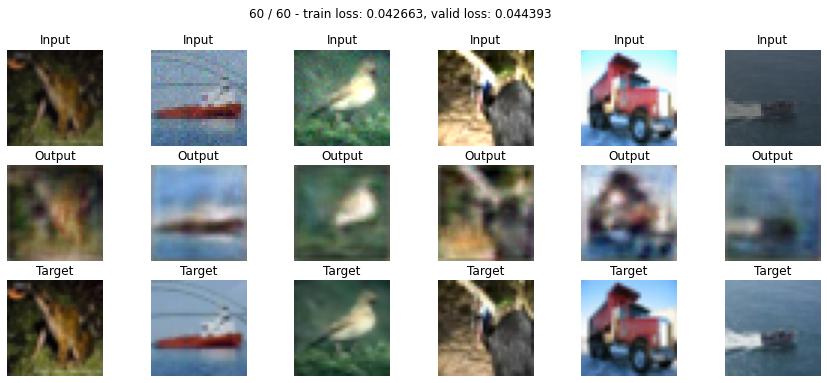

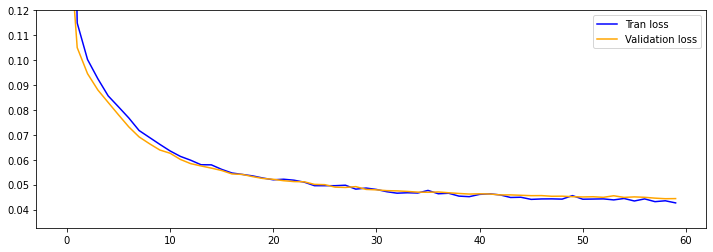

In [36]:
net = smp.UnetPlusPlus(   #smp.Unet, 
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)
model = net.to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=0.5, last_epoch=-1, verbose=False)

train2(model, optimizer, 60, scheduler)

### Unet++ with Adam optimizer

Loss is much lower than for SGD optimizer but the learning curve is crazy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


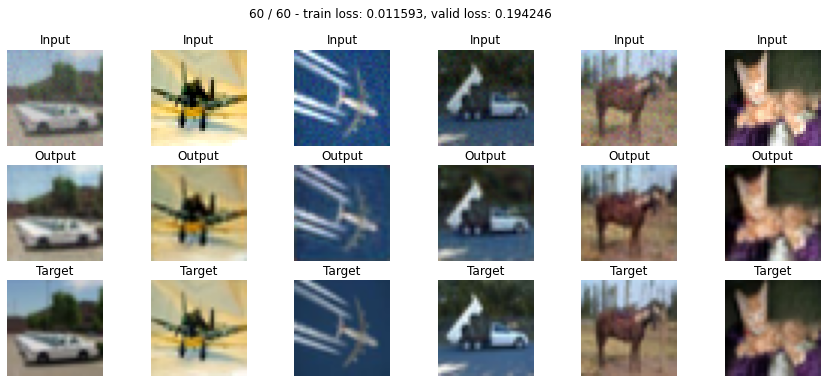

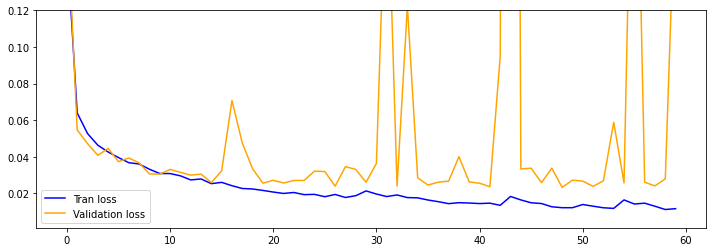

In [37]:
net = smp.UnetPlusPlus(   #smp.Unet, 
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)
model = net.to(device)

optimizer = optim.Adam(model.parameters())
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=0.5, last_epoch=-1, verbose=False)
train2(model, optimizer, 60)

### Unet++ with batch normalization and Adam optimizer

Learning curve is now much more "calm", loss is similar. 60 epoch seems to be too much.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


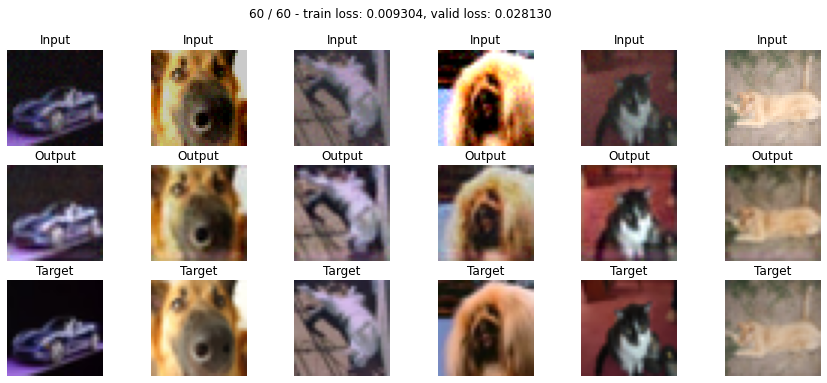

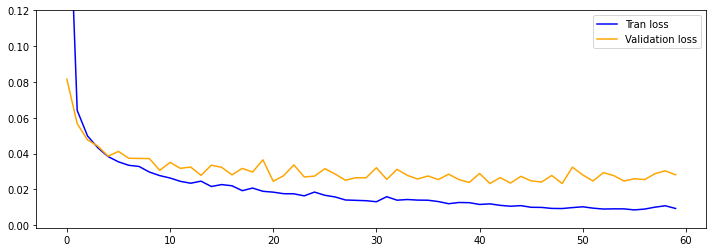

In [47]:
netBatchNorm = smp.UnetPlusPlus(   #smp.Unet, 
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
    decoder_use_batchnorm = True
    # aux_params={
    #     'classes':3,
    #     'dropout': 0.15,
    #     'pooling': 'avg',
    #     'activation': None
    #     }
)
model = netBatchNorm.to(device)

optimizer = optim.Adam(model.parameters())
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=0.5, last_epoch=-1, verbose=False)
train2(model, optimizer, 60)